In [1]:
import numpy as np
import pandas as pd
import os
import time
from gensim.parsing.preprocessing import remove_stopwords
from gensim import models
from pathlib import Path
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from string import digits

2022-06-12 20:07:58.333700: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# loading datasets and preliminary cleaning

subtitles=pd.read_csv('../data/movies_subtitles.csv')
metas=pd.read_csv('../data/meta_rotten_drama.csv')

indexes=list(metas['imdb_id'])
subtitles=subtitles.loc[subtitles['imdb_id'].isin(indexes)] # remove all movies that are not in metas dataset
print("{} subtitles from {} movies".format(len(subtitles), len(indexes)))

2920612 subtitles from 1325 movies


In [3]:
# load NLU model

model = GPT2LMHeadModel.from_pretrained('gpt2')  
word_embeddings = model.transformer.wte.weight  
position_embeddings = model.transformer.wpe.weight 
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [11]:
# clean subtitle's text



def clean_text(x):
    '''
    method to normalize the movie titles
    '''
    x=x.lower()  
    
    
    for char in ["\n", "'"]:
        x=x.replace(char, " ")  
    for char in ["-", ",", ".", ":", ";", "(", ")", "/", "!", "?", "%", "<i>", "<u>", 
                 "<b>", "♪", " s ", " m ", " t ", " ve ", "#"]:
        x=x.replace(char, "") 

    x=remove_stopwords(x)
    return x
 
subtitles=subtitles.dropna()

subtitles['text']=subtitles['text'].apply(clean_text)


movies_list=[]

for index in subtitles['imdb_id'].unique()[:10]:
    globals()['%s' % index]= subtitles.loc[subtitles['imdb_id']==index]
    movies_list.append(globals()['%s' % index])

4110                       turn
4111                 tall short
4112                      round
4113           like cat cat hat
4114       look eyes honest god
                   ...         
5587353      hold hand half way
5587354            hold hand ll
5587355                        
5587356                 someday
5587357                        
Name: text, Length: 2911581, dtype: object
4110                       turn
4111                 tall short
4112                      round
4113           like cat cat hat
4114       look eyes honest god
                   ...         
5587353      hold hand half way
5587354            hold hand ll
5587355                        
5587356                 someday
5587357                        
Name: text, Length: 2911581, dtype: object


In [5]:
# create dataframe with subtitles of every movie

movies_ids=list(subtitles['imdb_id'].unique())
movies_list=[]

for index in movies_ids[:5]:
    globals()['%s' % index]= subtitles.loc[subtitles['imdb_id']==index]
    movies_list.append(globals()['%s' % index])

In [9]:
matrix_subtitles=pd.DataFrame(movies_list, columns=["movie"])
print(matrix_subtitles)

/home/piegarroni/anaconda3/envs/condaenv/lib/python3.9/site-packages/pandas/core/internals/construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


ValueError: Shape of passed values is (5, 1), indices imply (5, 2)

In [20]:
# creating the matrix for every movie

remove_digits = str.maketrans('', '', digits) # object to remove numbers

matrix_subtitles=[]#pd.DataFrame(movies_list, columns=["movie"])

for movie in movies_list[:5]:
        
    dimension=int(len(movie)/768)
    low_bound=0
    high_bound=dimension   
 
    movie_words=[]
    
    # for every split of one movie's subtitle get list of words
    for i in range(768):
        text=[]
        subset=movie.iloc[low_bound:high_bound]       
        text+=subset['text'].to_string().split() # split string
        text = [x for x in text if not (x.isdigit())]  # remove numbers (index)
        globals()['sentences_%s' % i]=text
        low_bound+=dimension
        high_bound+=dimension
        movie_words.append(globals()['sentences_%s' % i])  # append list of words to movie_words
        
        
################ split for time comlexity????
    matrix=[]

    # for every list of words obtain vector and append to matrix
    for sentence in movie_words:
        sent_vect=[]
        for word in sentence:
            text_index = tokenizer.encode(word,add_prefix_space=True)
            vector = model.transformer.wte.weight[text_index,:]
            vector=vector.detach().numpy()         
            sent_vect.append(vector[0])
        matrix.append(np.sum(sent_vect, axis=0) / len(sent_vect))  
   
    matrix_subtitles.append(matrix)


        

In [21]:
print(len(matrix_subtitles))

5


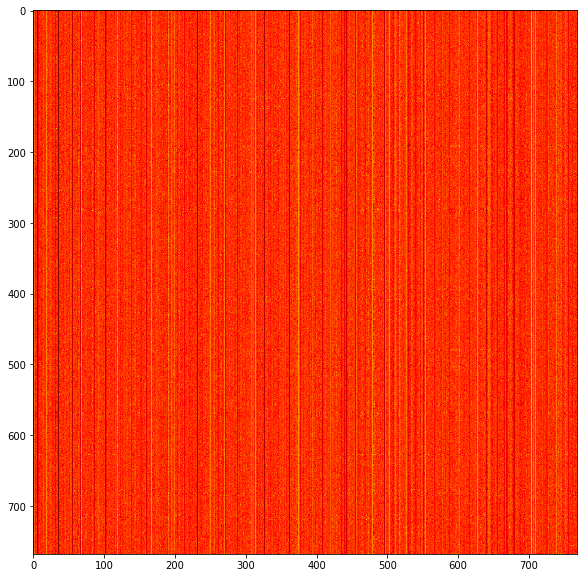

In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(matrix_subtitles[0], cmap='hot', interpolation='nearest')
plt.show()

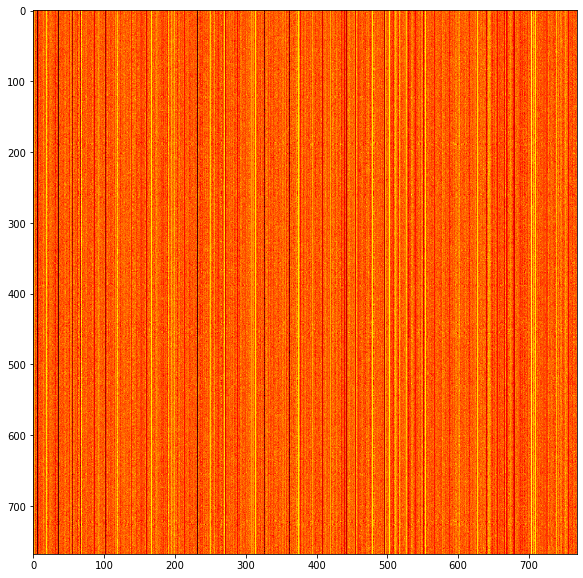

In [23]:
plt.figure(figsize=(10, 10))
plt.imshow(matrix_subtitles[3], cmap='hot', interpolation='nearest')
plt.show()

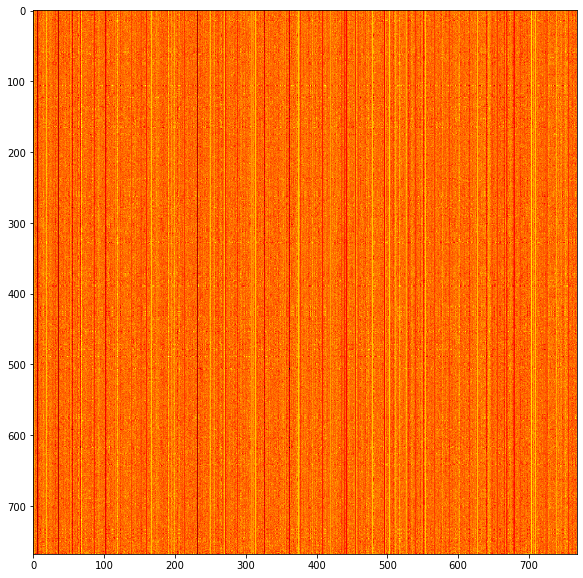

In [25]:
plt.figure(figsize=(10, 10))
plt.imshow(matrix_subtitles[4], cmap='hot', interpolation='nearest')
plt.show()